Extract Features MFCCS

In [48]:
import os
import pandas as pd
import soundfile as sf 
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.metrics import accuracy_score
from google.colab import drive

In [1]:
# monte o drive para acessar os dados do VERBO 
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
VERBO = '/content/drive/MyDrive/VERBO_OK/'
dir_list = os.listdir(VERBO)
dir_list.pop(3)

'features'

In [7]:
emotion = []
gender = []
path = []
for i in dir_list:
    fname = os.listdir(VERBO + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(part[0])
        temp = part[1]
        if temp == "f1" or temp =='f2' or temp == 'f3' or temp == 'f4' or temp == 'f5' or temp == 'f6':
            temp = "feminino"
        else:
            temp = "masculino"
        gender.append(temp)
        path.append(VERBO + i + '/' + f)

        
VERBO_df = pd.DataFrame(emotion)
VERBO_df = VERBO_df.replace({'neu':'neutro', 'des':'desgosto', 'ale':'alegre', 'tri':'triste', 'rai':'raiva', 'med':'medo', 'sur':'surpresa'})
VERBO_df = pd.concat([pd.DataFrame(gender),VERBO_df],axis=1)
VERBO_df.columns = ['gender','emotion']
VERBO_df['labels'] = VERBO_df.gender + '_' + VERBO_df.emotion
VERBO_df['source'] = 'VERBO'  
VERBO_df = pd.concat([VERBO_df,pd.DataFrame(path, columns = ['path'])],axis=1)
#VERBO_df = VERBO_df.drop(['gender', 'emotion'], axis=1)
#VERBO_df.labels.value_counts()
VERBO_df.head(5)

,gender,emotion,labels,source,path
0,feminino,desgosto,feminino_desgosto,VERBO,/content/drive/MyDrive/VERBO_OK/f3/des-f3-l1.wav
1,feminino,medo,feminino_medo,VERBO,/content/drive/MyDrive/VERBO_OK/f3/med-f3-l1.wav
2,feminino,neutro,feminino_neutro,VERBO,/content/drive/MyDrive/VERBO_OK/f3/neu-f3-ns4.wav
3,feminino,alegre,feminino_alegre,VERBO,/content/drive/MyDrive/VERBO_OK/f3/ale-f3-ns2.wav
4,feminino,alegre,feminino_alegre,VERBO,/content/drive/MyDrive/VERBO_OK/f3/ale-f3-ns1.wav


In [63]:
def audio_features_MFCC(file_title):
    with sf.SoundFile(file_title) as audio_recording:
        audio = audio_recording.read(dtype="float32")
        sample_rate = audio_recording.samplerate 
        result=np.array([])       
        mfccs=np.mean(librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))    
    return result

In [71]:
def loading_audio_data():
    x = []
    y = []
    for file in VERBO_df['path']:        
        emotion = file.split('/')[6].split('-')[0]             
        feature = audio_features_MFCC(str(file))
        
        x.append(feature)   
        y.append(emotion)

    return {"X":x,"y":y}
    

In [72]:
import time
start_time = time.time()

Trial_dict = loading_audio_data()

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 24.492483615875244 seconds ---


In [78]:
X = pd.DataFrame(Trial_dict["X"])
y = pd.DataFrame(Trial_dict["y"])

In [74]:
X.shape, y.shape

((1168, 40), (1168, 1))

In [92]:
#renaming the label column to emotion
y=y.rename(columns= {0: 'emotion'})
data = pd.concat([X, y], axis =1)
cols = data.columns.tolist()
cols = cols[-1:] + cols[:-1]
data = data[cols]
data

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,des,-299.244476,134.937912,-38.547646,32.485504,3.204261,-26.618738,14.904951,-7.597967,-9.162752,4.662045,-11.622400,-3.855593,-6.554804,-13.773700,-2.608310,-7.527237,-4.670477,0.697392,-9.785432,-4.865035,-2.856929,-9.714797,-2.941893,-4.022176,-7.476486,-1.894922,-4.093746,-2.224765,2.169287,0.460872,6.342788,7.944646,4.955812,7.856286,4.108639,2.609336,4.280911,0.224271,3.728909,5.090572
1,med,-280.755219,126.081894,-41.298115,38.425438,0.828395,-24.939224,19.244261,-11.226633,-9.258340,3.081147,-17.815662,-2.693212,-3.222776,-11.625367,0.875252,-8.848180,-7.264411,1.203914,-10.972466,-5.013815,-2.063886,-11.895419,-3.339726,-3.934288,-8.959902,-2.532706,-8.313913,-6.119390,3.669958,1.787428,8.762587,11.925750,7.551251,9.200706,2.482389,2.761377,7.229163,0.452960,4.331350,5.395949
2,neu,-289.371674,163.568909,-42.457962,31.825321,9.872895,-18.090706,15.875987,-11.537040,-8.125425,0.530380,-17.792027,-1.966992,-2.961759,-7.976524,0.711579,-12.484450,-5.248092,2.978511,-13.843119,-5.348973,0.686069,-11.644198,-6.281087,-5.437551,-8.937038,-3.735828,-6.220537,-1.735462,0.900201,-7.883902,-2.561250,-0.950544,-4.833997,2.501456,0.179654,-0.101232,7.432496,6.438443,9.989048,10.347374
3,ale,-289.829590,122.062752,-47.390533,30.187838,6.926980,-19.324974,8.132305,-19.527636,-6.840974,3.717316,-18.629246,-3.734191,-7.389874,-12.683773,2.828109,-10.750315,-9.235787,3.774590,-8.282649,-4.805080,1.280329,-5.235325,-0.304205,-1.263289,-4.907875,-0.458500,-0.603904,4.436168,6.061274,1.145645,5.863343,1.454023,-3.912467,3.030716,-1.044044,-2.317915,3.152509,-0.738592,1.187798,4.010984
4,ale,-253.765579,157.213974,-55.141525,26.518539,2.841007,-21.679552,12.843037,-16.090603,-3.021253,7.149221,-14.612515,0.835789,-5.195010,-9.742453,2.814099,-11.553067,-6.538216,1.238463,-11.794512,-4.088756,-1.457239,-7.344140,0.964859,-1.949142,-3.119444,4.733239,-0.046918,0.064440,1.419936,-4.135865,1.099942,1.722127,-0.706707,5.784656,4.278145,4.550119,6.335617,0.084374,0.971715,-0.456071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,rai,-183.381912,104.789337,14.807039,-9.672712,-6.459239,22.275301,-15.362299,-3.511589,-6.818185,-2.652336,-14.710246,2.959188,-12.360679,-2.521060,-3.964326,7.648031,-7.394562,7.435741,-10.081418,0.600119,-5.337340,1.549539,-9.154539,2.787532,-12.210612,-2.672940,-6.649271,2.951764,-8.714530,3.518996,-7.182069,0.295285,-5.939539,0.105416,-7.892310,-0.272436,-9.534084,-2.516351,-10.488039,0.082739
1164,sur,-168.763092,69.961540,4.856296,6.709993,-4.954771,16.218691,-21.581753,-17.088322,-15.802592,0.064830,-20.791382,-7.436071,-10.392581,-0.421666,-17.951622,-0.481544,-8.983899,0.946325,-14.862037,-2.153126,-10.337239,-2.237139,-10.764190,6.132142,-8.123683,5.164895,-2.219543,12.866432,1.128578,12.086308,1.105813,11.755951,-0.267902,7.042945,0.667894,8.061094,-1.496503,5.407216,-4.816868,3.877920
1165,sur,-197.754654,57.595177,11.844243,15.256923,-3.609420,17.730558,-17.815870,-18.759687,-14.951108,1.754533,-21.413151,-8.789320,-14.282114,0.353392,-17.766882,-7.510611,-12.317961,0.619248,-12.611516,-2.820594,-10.624775,-0.985336,-5.822318,8.755358,-6.255806,11.334776,1.253069,11.042601,-2.753516,9.436544,-3.689944,5.533223,-4.322696,6.429312,-1.420542,4.590117,-3.639744,3.307014,-3.927598,2.898216
1166,med,-181.388840,85.465805,1.650203,4.989377,9.457479,18.850460,-8.209545,7.544348,-22.032797,1.836285,-23.831577,-5.945150,-15.134949,-4.104238,-14.195700,2.097072,-11.605044,1.109447,-10.540604,-0.574141,-5.950006,-0.305174,-9.543948,2.005487,-9.505818,0.946055,-11.221388,-4.524084,-9.079027,-5.145490,-14.498576,-3.387048,-10.812784,-2.691946,-11.365395,-3.237841,-5.289690,2.339355,0.057275,11.052513


In [95]:
data = data.reindex(np.random.permutation(data.index))

In [97]:
data

,emotion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
383,med,-264.575592,130.285446,-26.073854,18.074808,14.153781,22.714178,-16.193499,-10.252567,5.666986,-11.880415,-28.163811,0.025416,-15.954173,-17.573496,3.735583,-15.112044,-7.265766,-3.706454,-2.136021,-9.878043,-9.530407,0.982240,-4.973524,-6.877205,-8.215983,-3.463153,-7.864753,-3.588989,-7.421807,-3.128881,-5.933743,-9.026754,-5.962086,-8.676147,-5.493057,-0.828778,-3.837524,-0.486762,-0.225208,-0.135887
115,sur,-221.562592,132.651428,-13.281281,48.523228,0.233749,16.115372,-28.058571,-1.830076,-15.435079,-15.494793,-15.947625,-13.854774,-10.214729,-9.598344,1.736120,-24.526609,-0.292108,-2.958112,-12.495849,-14.223632,2.267883,6.666430,-6.116266,6.255541,2.499313,4.716085,5.141765,7.130899,4.886462,10.183178,9.594508,2.005501,-0.079724,3.752283,4.238250,3.104111,5.541846,-1.704234,3.399171,0.629548
447,rai,-229.215500,130.265732,-55.197746,1.510071,6.944549,11.584821,-13.266697,-6.544347,-11.814191,-14.175822,-30.788101,3.417075,-7.014583,-15.149282,-4.415112,-11.450731,-6.959331,-4.724225,-8.062578,4.042225,-17.154245,-5.684399,-6.909870,-4.731059,-7.343509,-4.805856,-3.186548,-2.610428,-7.872740,-0.972020,-3.595400,-4.795673,-2.017555,-5.379217,-2.478461,0.472585,1.778797,1.936437,2.287365,5.735839
569,neu,-199.100983,121.078461,22.698408,34.513855,-5.095586,-6.389561,-7.573924,-11.669936,2.049757,-5.109477,-3.294523,-0.205098,-14.187895,-2.807696,-11.339463,2.341182,-5.454646,3.636798,-6.104137,-2.239921,-11.821444,0.350253,-7.208769,2.054716,-7.038365,0.005184,-11.636672,-5.675443,-6.951874,-1.418214,-8.770733,0.607635,-7.056389,-0.681275,-7.195282,-1.462087,-5.185653,-0.511211,-5.799866,-0.558721
215,tri,-334.814789,98.203583,29.705946,35.214897,13.587405,-3.457274,-12.189611,-1.244765,-40.623760,-8.409569,-0.426568,-12.528638,-4.136507,-4.404785,-9.368823,0.447348,-6.645897,-1.898227,-5.322394,-5.084718,-7.155218,0.199517,-9.530564,-5.200235,-1.558762,-4.908151,-4.839035,-5.030124,-5.761814,-1.483653,-9.144315,-4.441563,-5.386304,-6.981078,-0.316726,-6.694266,-1.554921,-3.148857,-3.164370,1.750118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,neu,-369.896576,158.679153,-13.005588,33.899879,8.928900,-11.329848,6.011229,-10.895184,-10.985461,-12.777090,-11.368014,-3.458304,-6.630300,1.642344,-1.317714,-7.290534,1.501050,-5.029347,-10.098334,-2.285958,-3.624876,-7.295428,-4.447101,-2.452465,-3.765482,-3.899347,-3.612987,-3.423666,-2.214071,-4.345472,-3.530089,0.640691,0.595383,1.933138,3.660360,4.616138,7.594579,9.752658,9.169312,5.524381
251,ale,-147.419312,85.346085,-9.298602,-0.031357,-0.613556,-16.442879,-18.065348,-12.510987,-33.985962,7.700841,-9.411318,-7.850735,-14.986526,-8.213786,-9.160970,-0.566216,-10.096625,-7.026003,-12.866479,-3.501611,-11.490853,-2.885401,-10.649588,-7.065922,-7.288245,-8.032702,4.037998,2.600193,3.877537,5.035678,4.569480,6.926870,7.739581,7.143492,2.137386,5.218361,-6.164259,1.357495,-3.376571,0.254263
124,rai,-221.646759,154.564758,-5.108234,45.584511,4.760395,11.928919,-16.500906,-3.619299,-14.517721,-8.596875,-3.204843,-11.851026,-9.853251,0.506602,6.859248,-19.094452,-1.268641,1.949342,-6.925359,-9.998279,-4.481970,-2.753739,-6.365439,-2.628253,-5.776367,-2.620015,-5.507271,-2.414081,-6.156767,-2.467512,-2.117648,0.463084,5.215292,2.454342,7.053066,1.076100,1.727805,0.057153,3.152204,6.590435
1113,ale,-210.651184,89.122559,10.240124,21.578585,-1.147068,16.537539,-2.591742,-3.778094,-11.535473,-7.530898,-23.331703,-0.811278,-15.456935,-2.844621,-12.897062,-0.270728,-9.206958,-0.886614,-12.814568,-2.286105,-7.275732,-2.097583,-6.349483,-0.698667,-9.601393,1.894188,-5.729966,5.795693,-0.055946,6.902437,-1.638822,8.004159,-4.637936,4.070290,1.032634,3.806595,-2.753360,4.638169,-1.398591,5.598704


In [98]:
data.to_csv("VERBO_OK_MFCC_Observed.csv")

# SVM

Data Preparations

In [102]:
import time

starting_time = time.time()
data = pd.read_csv('/content/VERBO_OK_MFCC_Observed.csv')
print("data loaded in " + str(time.time()-starting_time) + "ms")

print(data.head())

data loaded in 0.025632858276367188ms
   Unnamed: 0 emotion           0  ...        37        38        39
0         383     med -264.575592  ... -0.486762 -0.225208 -0.135887
1         115     sur -221.562592  ... -1.704234  3.399171  0.629548
2         447     rai -229.215500  ...  1.936437  2.287365  5.735839
3         569     neu -199.100983  ... -0.511211 -5.799866 -0.558721
4         215     tri -334.814789  ... -3.148857 -3.164370  1.750118

[5 rows x 42 columns]


In [103]:
data.shape

(1168, 42)

In [109]:
data.columns

Index(['emotion', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35',
       '36', '37', '38', '39'],
      dtype='object')

In [110]:
#data = data.drop('Unnamed: 0',axis=1)


In [111]:
X = data.drop('emotion', axis = 1).values
y = data['emotion'].values

Implementing SVM with Scikit-Learn

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
X.shape, y.shape

((1168, 40), (1168,))

In [116]:
np.unique(y)

array(['ale', 'des', 'med', 'neu', 'rai', 'sur', 'tri'], dtype=object)

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [118]:

from sklearn.svm import SVC

svclassifier = SVC(kernel = 'linear')

In [119]:

import time

starting_time = time.time()
svclassifier.fit(X_train, y_train)
print("Trained model in %s ms " % str(time.time() - starting_time))

Trained model in 10.410248517990112 ms 


In [120]:
y_pred = svclassifier.predict(X_test)

              precision    recall  f1-score   support

         ale       0.54      0.65      0.59        40
         des       0.54      0.66      0.59        29
         med       0.62      0.62      0.62        26
         neu       0.68      0.81      0.74        32
         rai       0.63      0.55      0.59        31
         sur       0.66      0.61      0.63        38
         tri       0.88      0.58      0.70        38

    accuracy                           0.64       234
   macro avg       0.65      0.64      0.64       234
weighted avg       0.65      0.64      0.64       234

----accuracy score 63.67521367521367 ----


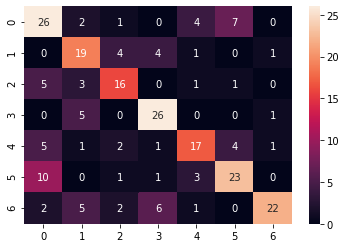

In [121]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(y_test,y_pred))

acc = float(accuracy_score(y_test,y_pred))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()

In [122]:
train_acc = float(svclassifier.score(X_train, y_train)*100)
print("----train accuracy score %s ----" % train_acc)

test_acc = float(svclassifier.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)

----train accuracy score 79.97858672376874 ----
----test accuracy score 63.67521367521367 ----


CROSS VALIDATION

In [123]:
from sklearn.model_selection import cross_val_score

# no. of folds cv = 5
cv_results = cross_val_score(svclassifier, X, y, cv = 5)
print(cv_results)

[0.59401709 0.66666667 0.58119658 0.58369099 0.59227468]


SCALING

In [124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC


#splitting dataset into train/ test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('SVM', SVC())]
        
# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: svc_scaled
svc_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a classifier to the unscaled data
svc_unscaled = SVC(kernel = 'linear').fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(svc_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(svc_unscaled.score(X_test, y_test)))

Accuracy with Scaling: 0.7478632478632479
Accuracy without Scaling: 0.6153846153846154


In [125]:
train_acc = float(svc_scaled.score(X_train, y_train)*100)
print("----train accuracy score %s ----" % train_acc)

test_acc = float(svc_scaled.score(X_test, y_test)*100)
print("----test accuracy score %s ----" % test_acc)

----train accuracy score 94.00428265524626 ----
----test accuracy score 74.78632478632478 ----


In [126]:
scaled_predictions = svc_scaled.predict(X_test)

              precision    recall  f1-score   support

         ale       0.74      0.74      0.74        31
         des       0.73      0.65      0.69        34
         med       0.82      0.78      0.80        41
         neu       0.79      0.90      0.84        29
         rai       0.58      0.70      0.64        30
         sur       0.74      0.64      0.69        36
         tri       0.82      0.85      0.84        33

    accuracy                           0.75       234
   macro avg       0.75      0.75      0.75       234
weighted avg       0.75      0.75      0.75       234

----accuracy score 74.78632478632478 ----


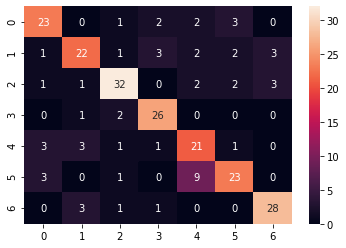

In [127]:
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import seaborn as sn

print(classification_report(y_test,scaled_predictions))

acc = float(accuracy_score(y_test,scaled_predictions))*100
print("----accuracy score %s ----" % acc)

cm = confusion_matrix(y_test,scaled_predictions)
df_cm = pd.DataFrame(cm)
sn.heatmap(df_cm, annot=True, fmt='')
plt.show()